In [16]:
#API Calls - Chicago

import requests
import pandas as pd

#chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ejscreen.epa.gov/mapper/EJAPIinstructions.pdf
#https://ejscreen.epa.gov/mapper/ejsoefielddesc1.html
#https://www.epa.gov/ejscreen/ejscreen-api

# Load the CSV file
file_path = './data_files/Chicago_Tract_ID.csv'
chicago_tracts_df = pd.read_csv(file_path)

def process_tract_id(tract_id):
    # Remove the dot and convert to an integer
    processed_id = int(tract_id * 100)
    # Convert to string
    processed_str = str(processed_id)
    # Pad with zeros on the right to ensure it's 6 digits long
    processed_str = processed_str.ljust(6, '0')
    return processed_str

base_fips = "17031"

# Apply the processing function to the DataFrame
chicago_tracts_df['Processed'] = chicago_tracts_df.iloc[:, 0].apply(process_tract_id)
chicago_tracts_df['FIPS'] = base_fips + chicago_tracts_df['Processed']

# Convert the list of FIPS codes to a set for efficiency
fips_codes = set(chicago_tracts_df['FIPS'])

# DataFrame to store all results
chicago_data = pd.DataFrame()

# Initialize counters for tracking API calls
success_count = 0
fail_count = 0

# Limit the loop to 100 API calls
for i, fips_code in enumerate(fips_codes):
    if i >= 400:
        break  # Exit the loop after n iterations

    # Modify the areatype to "tract"
    url = f"https://ejscreen.epa.gov/mapper/ejscreenRESTbroker1.aspx?namestr={fips_code}&geometry=&distance=&unit=9035&areatype=tract&areaid={fips_code}&f=json"
    response = requests.get(url)
    
    data = response.json()
    if 'data' in data:
        df = pd.json_normalize(data['data'])
        chicago_data = pd.concat([chicago_data, df], ignore_index=True)
        success_count += 1
    else:
        fail_count += 1

# Display the counts and the first few rows of the combined data
print (f"Success: {success_count}, Failures: {fail_count}")
chicago_data[["main.NUM_HOSPITAL","demographics.P_NHBLACK","demographics.TOTALPOP", "main.NUM_TRI"]]



Success: 352, Failures: 48


,main.NUM_HOSPITAL,demographics.P_NHBLACK,demographics.TOTALPOP,main.NUM_TRI
0,0,4,3021,0
1,0,0,5748,0
2,0,3,4569,0
3,0,2,4862,0
4,0,64,4855,6
...,...,...,...,...
347,0,10,1610,0
348,0,78,3583,0
349,0,1,4459,1
350,0,89,1529,0


In [17]:
#Exploring Data

chicago_data.describe()
chicago_data.shape


(352, 317)

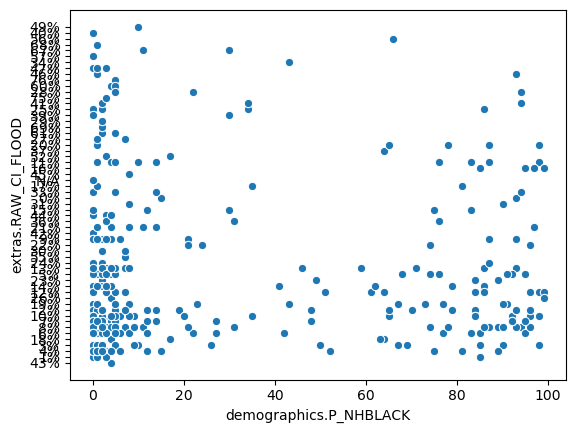

In [20]:
#Visualizing Data

#If you don't already have seaborn
# %pip install --upgrade seaborn
# %pip install --upgrade numpy

import seaborn as sns 
import pandas as pd

#Setting the theme
# sns.set(style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

#Convert to numeric
chicago_data[["demographics.P_NHBLACK", "main.NUM_AIRPOLL", "main.NUM_TRI"]] = chicago_data[["demographics.P_NHBLACK", "main.NUM_AIRPOLL", "main.NUM_TRI"]].apply(pd.to_numeric)


# sns.pairplot(chicago_data, vars =["demographics.P_NHBLACK", "main.NUM_AIRPOLL", "main.NUM_TRI"],height=2)
sns.scatterplot(x="demographics.P_NHBLACK", y="extras.RAW_CI_FLOOD", data= chicago_data)


#Outliers problematic

In [21]:
#Pandas DF to SQL DB

#inspired by https://stackoverflow.com/questions/30631325/writing-to-mysql-database-with-pandas-using-sqlalchemy-to-sql
# %pip install sqlalchemy

import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data_files/chicago_epa.db')

chicago_data.to_sql('chicago_epa', engine, index=False, if_exists='replace')

352

In [22]:
#Check SQL Database

from sqlalchemy import create_engine, text

# Create an engine that connects to the SQLite database file in your data_files directory
engine = create_engine('sqlite:///data_files/chicago_epa.db')

# Connect to the database
with engine.connect() as connection:
    # Execute a simple SQL query to count the rows in the chicago_epa table
    row_count = connection.execute(text("SELECT COUNT(*) FROM chicago_epa")).fetchone()[0]

print(f"The number of rows in the 'chicago_epa' table is: {row_count}")

The number of rows in the 'chicago_epa' table is: 352
